In [7]:
!pip install opencv-python

^C
ERROR: Operation cancelled by user


In [8]:
conda install pytorch torchvision -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /Users/callamingram/opt/anaconda3

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ffmpeg-4.3                 |       h0a44026_0        10.1 MB  pytorch
    gnutls-3.6.15              |       hed9c0bf_0         974 KB
    lame-3.100                 |       h1de35cc_0         316 KB
    libtasn1-4.16.0            |       h9ed2024_0          53 KB
    nettle-3.7.3               |       h230ac6f_1         380 KB
    openh264-2.1.1             |       h8346a28_0         655 KB
    pytorch-1.13.1             |          py3.9_0        71.9 MB  pytorch
    torchvision-0.14.1         |         py39_cpu         6.1 MB  pytorch
    ------------------------------------------------------------
                                           Total:        90.4 MB

The following

In [9]:
#=============================================================================================================#
#                                                   IMPORTS                                                   #
#=============================================================================================================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from PIL import Image
import cv2
import csv
import copy

from collections import OrderedDict
from scipy import spatial
import glob

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models
import torchvision.transforms as transforms


import pickle
from joblib import dump, load



import warnings
warnings.filterwarnings('ignore')

In [100]:
data_dir = '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs'

In [92]:
# Image Processing Parameters 
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 20
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0, 0.0, 1.0) # In BGR format

In [93]:
#Image preprocessing. Create mask and remove backgrounds

def preprocess(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.findContours


    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)

    #-- Create final image ---------------------------------------------------------------
    img[mask <= 100] = 0
    return img
 

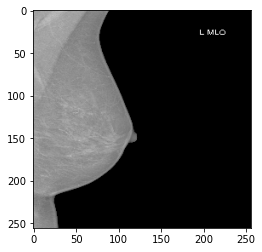

In [107]:
# Preprocessing an example image
filename = 'rsna-breast-cancer/rsna-breast-cancer-256-pngs/5_640805896.png'
img = cv2.imread(filename)
plt.imshow(img);



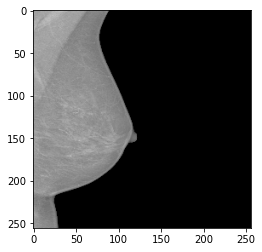

In [110]:

img = preprocess(filename)
plt.imshow(img);

In [116]:
test_files = glob.glob(os.path.join(data_dir, "10006*.png"))
print(test_files)

['/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1459541791.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1864590858.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1874946579.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_462822612.png']


In [127]:
df = pd.read_csv('./train.csv')

# print(df)


In [135]:
# Test Data: 
# 10006 1459541791 L MLO 61
# 10006 1864590858 R MLO 61

# 10006 462822612 L CC 61
# 10006 1874946579 R CC 61

def get_image_ids(df, patient_id, view):
    image_ids_L = df[(df['patient_id'] == patient_id) & (df['view'] == view) & (df['laterality'] == 'L')]['image_id'].tolist()
    image_ids_R = df[(df['patient_id'] == patient_id) & (df['view'] == view) & (df['laterality'] == 'R')]['image_id'].tolist()
    image_ids = {'L': image_ids_L, 'R': image_ids_R}
    return image_ids


def get_patient_ids(df):
    patient_ids = df['patient_id'].unique().tolist()
    return patient_ids

    

view = 'MLO'
patient_id = 10006
image_ids = get_image_ids(df, patient_id, view)

print("Image ids for MLO view of left laterality: ", image_ids['L'])
print("Image ids for MLO view of right laterality: ", image_ids['R'])

view = 'CC'
image_ids = get_image_ids(df, patient_id, view)

print("Image ids for CC view of left laterality: ", image_ids['L'])
print("Image ids for CC view of right laterality: ", image_ids['R'])

Image ids for MLO view of left laterality:  [1459541791]
Image ids for MLO view of right laterality:  [1864590858]
Image ids for CC view of left laterality:  [462822612]
Image ids for CC view of right laterality:  [1874946579]


In [189]:
# --------Concatenate and preprocess images---------

patient_ids = get_patient_ids(df)
proc_data_dir = '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/processed'

def concatenate_and_save_images(view): 
    image_ids = get_image_ids(df, patient_id, view)
    filename_L =  str(patient_id) + "_" + str(image_ids['L'][0]) + '.png'
    filename_R =  str(patient_id) + "_" + str(image_ids['R'][0]) + '.png'
    left_img = preprocess(data_dir + '/' + filename_L)
    right_img = preprocess(data_dir + '/' + filename_R)

    concatenated_img = cv2.hconcat([right_img, left_img])
    concatenated_img = concatenated_img[0:336, 128:384]
    cated_img_name = str(patient_id) + "_" + view
    print(cated_img_name)

    # cv2.imwrite(os.path.join(proc_data_dir, os.path.splitext(cated_img_name) + '.png'), concatenated_img)
    cv2.imwrite(os.path.join(proc_data_dir, cated_img_name + '.png'), concatenated_img)



for patient_id in patient_ids: 
    concatenate_and_save_images('MLO')
    concatenate_and_save_images('CC')





10006_MLO
10006_CC
10011_MLO
10011_CC
10025_MLO
10025_CC
10038_MLO
10038_CC
10042_MLO
10042_CC
10048_MLO
10048_CC
10049_MLO
10049_CC
10050_MLO
10050_CC
10051_MLO
10051_CC
10086_MLO
10086_CC
10095_MLO
10095_CC
10097_MLO
10097_CC
10102_MLO
10102_CC
10106_MLO
10106_CC
10116_MLO
10116_CC
10119_MLO
10119_CC
10122_MLO
10122_CC
10124_MLO
10124_CC
10126_MLO
10126_CC
10130_MLO
10130_CC
10132_MLO
10132_CC
10136_MLO
10136_CC
1014_MLO
1014_CC
10144_MLO
10144_CC
1015_MLO
1015_CC
10151_MLO
10151_CC
10152_MLO
10152_CC
10153_MLO
10153_CC
10175_MLO
10175_CC
10179_MLO
10179_CC
10182_MLO
10182_CC
10183_MLO
10183_CC
10185_MLO
10185_CC
10188_MLO
10188_CC
10198_MLO
10198_CC
10200_MLO
10200_CC
10208_MLO
10208_CC
10215_MLO
10215_CC
10217_MLO
10217_CC
10219_MLO
10219_CC
10223_MLO
10223_CC
10224_MLO
10224_CC
10226_MLO
10226_CC
10232_MLO
10232_CC
10234_MLO
10234_CC
10240_MLO
10240_CC
10243_MLO
10243_CC
1025_MLO
1025_CC
10257_MLO
10257_CC
1026_MLO
1026_CC
10267_MLO
10267_CC
10273_MLO
10273_CC
1028_MLO
1028_CC
102

IndexError: list index out of range